# 📊 Crime Rate Prediction Model  
## 🔍 Using XG Boost Algorithm

---

In [45]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd


In [46]:
file_path = "/Users/harshbhalwar/Documents/crime_dataset_india.csv"
df = pd.read_csv(file_path)

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40160 entries, 0 to 40159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Report Number       40160 non-null  int64 
 1   Date Reported       40160 non-null  object
 2   Date of Occurrence  40160 non-null  object
 3   Time of Occurrence  40160 non-null  object
 4   City                40160 non-null  object
 5   Crime Code          40160 non-null  int64 
 6   Crime Description   40160 non-null  object
 7   Victim Age          40160 non-null  int64 
 8   Victim Gender       40160 non-null  object
 9   Weapon Used         34370 non-null  object
 10  Crime Domain        40160 non-null  object
 11  Police Deployed     40160 non-null  int64 
 12  Case Closed         40160 non-null  object
 13  Date Case Closed    20062 non-null  object
dtypes: int64(4), object(10)
memory usage: 4.3+ MB


(None,
    Report Number   Date Reported  ... Case Closed Date Case Closed
 0              1   02/01/20 0:00  ...          No              NaN
 1              2  01/01/20 19:00  ...          No              NaN
 2              3   02/01/20 5:00  ...          No              NaN
 3              4   01/01/20 5:00  ...         Yes    29/04/20 5:00
 4              5  01/01/20 21:00  ...         Yes   08/01/20 21:00
 
 [5 rows x 14 columns])

In [ ]:
unique_crimes = df["Crime Description"].unique()
no_of_unique_crimes = len(unique_crimes)
print(unique_crimes)
print(no_of_unique_crimes)

['IDENTITY THEFT' 'HOMICIDE' 'KIDNAPPING' 'BURGLARY' 'VANDALISM' 'ASSAULT'
 'VEHICLE - STOLEN' 'COUNTERFEITING' 'EXTORTION' 'PUBLIC INTOXICATION'
 'FRAUD' 'SEXUAL ASSAULT' 'DRUG OFFENSE' 'ARSON' 'CYBERCRIME'
 'TRAFFIC VIOLATION' 'SHOPLIFTING' 'ILLEGAL POSSESSION' 'FIREARM OFFENSE'
 'ROBBERY' 'DOMESTIC VIOLENCE']
21


In [27]:
detailed_crime_mapping = {
    "HOMICIDE": ["HOMICIDE"],
    "KIDNAPPING": ["KIDNAPPING"],
    "IDENTITY THEFT": ["IDENTITY THEFT"],
    "BURGLARY": ["BURGLARY"],
    "VANDALISM": ["VANDALISM"],
    "ASSAULT": ["ASSAULT", "SEXUAL ASSAULT"],
    "VEHICLE THEFT": ["VEHICLE - STOLEN"],
    "COUNTERFEITING": ["COUNTERFEITING"],
    "EXTORTION": ["EXTORTION"],
    "PUBLIC DISORDER": ["PUBLIC INTOXICATION"],
    "FRAUD": ["FRAUD"],
    "DRUG OFFENSE": ["DRUG OFFENSE"],
    "ARSON": ["ARSON"],
    "CYBERCRIME": ["CYBERCRIME"],
    "TRAFFIC VIOLATION": ["TRAFFIC VIOLATION"],
    "SHOPLIFTING": ["SHOPLIFTING"],
    "ILLEGAL POSSESSION": ["ILLEGAL POSSESSION"],
    "FIREARM OFFENSE": ["FIREARM OFFENSE"],
    "ROBBERY": ["ROBBERY"]
}

def categorize_crimes(description):
    for category, keywords in detailed_crime_mapping.items():
        if description in keywords:
            return category
    return 'OTHER'

df["Crime Category"] = df["Crime Description"].apply(categorize_crimes)

df[["City", "Crime Description", "Crime Category"]].head(20)

,City,Crime Description,Crime Category
0,Ahmedabad,IDENTITY THEFT,IDENTITY THEFT
1,Chennai,HOMICIDE,HOMICIDE
2,Ludhiana,KIDNAPPING,KIDNAPPING
3,Pune,BURGLARY,BURGLARY
4,Pune,VANDALISM,VANDALISM
5,Delhi,ASSAULT,ASSAULT
6,Chennai,VEHICLE - STOLEN,VEHICLE THEFT
7,Chennai,COUNTERFEITING,COUNTERFEITING
8,Mumbai,EXTORTION,EXTORTION
9,Chennai,PUBLIC INTOXICATION,PUBLIC DISORDER


In [28]:
crime_pivot  = df.pivot_table(index="City", columns="Crime Category", aggfunc="size", 
fill_value=0)

crime_pivot.reset_index(inplace=True)

crime_pivot.head(10)

Crime Category,City,ARSON,ASSAULT,BURGLARY,COUNTERFEITING,CYBERCRIME,DRUG OFFENSE,EXTORTION,FIREARM OFFENSE,FRAUD,HOMICIDE,IDENTITY THEFT,ILLEGAL POSSESSION,KIDNAPPING,OTHER,PUBLIC DISORDER,ROBBERY,SHOPLIFTING,TRAFFIC VIOLATION,VANDALISM,VEHICLE THEFT
0,Agra,43,77,32,40,32,31,39,40,33,32,37,30,38,38,43,40,37,33,33,36
1,Ahmedabad,80,205,94,84,87,82,83,88,85,76,83,89,86,102,82,94,85,81,76,75
2,Bangalore,154,331,187,176,155,168,188,164,152,182,177,176,168,171,198,167,167,166,179,162
3,Bhopal,38,71,23,29,31,30,26,28,38,35,35,33,42,34,41,28,35,31,33,29
4,Chennai,138,227,134,115,117,103,122,122,114,138,128,107,135,97,107,108,116,110,124,131
5,Delhi,227,485,254,254,286,278,246,291,281,270,272,250,260,275,246,280,244,198,256,247
6,Faridabad,19,39,11,14,13,12,13,17,11,15,25,18,21,20,18,18,16,18,22,14
7,Ghaziabad,35,63,37,32,27,40,32,24,34,28,33,33,36,40,40,41,27,42,31,29
8,Hyderabad,152,250,140,136,139,134,124,138,126,140,159,142,126,143,143,138,120,135,131,165
9,Indore,28,69,31,32,34,34,39,45,33,34,34,29,30,33,26,41,30,32,28,37


In [29]:
city_population = {
    'Agra' : 1585704,
    'Ahmedabad'  : 5570585, 
    'Bangalore' :8443675 , 
    'Bhopal' : 1798218, 
    'Chennai' : 7088000, 
    'Delhi' : 16787941, 
    'Faridabad' :1404653 , 
    'Ghaziabad' : 2358525, 
    'Hyderabad' :6809970 , 
    'Indore' : 1994397, 
    'Jaipur' : 3046163, 
    'Kalyan' : 1247327, 
    'Kanpur' : 2767031, 
    'Kolkata' : 4496694, 
    'Lucknow' : 2817105, 
    'Ludhiana' :1618879 , 
    'Meerut' : 1305429, 
    'Mumbai' : 12442373, 
    'Nagpur' : 2405665, 
    'Nashik' : 1486053, 
    'Patna' : 1684222, 
    'Pune' : 3124458, 
    'Rajkot' : 1390640,
    'Srinagar' : 1180570, 
    'Surat' : 4467797, 
    'Thane' : 1841488, 
    'Varanasi' :1198491 , 
    'Vasai' : 1958000, 
    'Visakhapatnam' :1728128 
}

city_unemployment_rate = {
    'Agra': 5.5,
    'Ahmedabad': 6.4,
    'Bangalore': 1.8,
    'Bhopal': 0.1,
    'Chennai': 3.0, 
    'Delhi': 2.1,
    'Faridabad': 3.0,
    'Ghaziabad': 3.0,
    'Hyderabad': 7.1,
    'Indore': 0.8,
    'Jaipur': 4.7,
    'Kalyan': 3.0,
    'Kanpur': 7.7,
    'Kolkata': 4.14,
    'Lucknow': 3.0,
    'Ludhiana': 6.3,
    'Meerut': 3.9,
    'Mumbai': 3.0,
    'Nagpur': 3.0,
    'Nashik': 3.0,
    'Patna': 13.2,
    'Pune': 3.0,
    'Rajkot': 3.0,
    'Srinagar': 3.0,
    'Surat': 0.6,
    'Thane': 3.0,
    'Varanasi': 3.0,
    'Vasai': 3.0,
    'Visakhapatnam': 3.0
}

city_literacy_rate = {
    'Agra' : 73.11,
    'Ahmedabad'  : 89.62, 
    'Bangalore' : 88.71, 
    'Bhopal' :85.24 , 
    'Chennai' : 90.33, 
    'Delhi' : 86.21, 
    'Faridabad' : 83.04, 
    'Ghaziabad' : 78.07, 
    'Hyderabad' : 83.26, 
    'Indore' : 82.32, 
    'Jaipur' : 84.34, 
    'Kalyan' : 89.41, 
    'Kanpur' : 79.65, 
    'Kolkata' : 87.14, 
    'Lucknow' : 84.72, 
    'Ludhiana' : 85.38, 
    'Meerut' : 76.28, 
    'Mumbai' : 90.28, 
    'Nagpur' : 91.92, 
    'Nashik' : 89.85, 
    'Patna' : 83.37, 
    'Pune' : 91.61, 
    'Rajkot' : 86.11, 
    'Srinagar' : 70.98, 
    'Surat' : 86.65, 
    'Thane' : 89.41, 
    'Varanasi' : 80.12, 
    'Vasai' : 85.00, 
    'Visakhapatnam' :81.79 
}

crime_pivot['Population'] = crime_pivot['City'].map(city_population)
crime_pivot['Unemployment Rate'] = crime_pivot['City'].map(city_unemployment_rate)
crime_pivot['Literacy Rate'] = crime_pivot['City'].map(city_literacy_rate)

In [44]:
# Calculate Crime Rate

crime_columns = ['ARSON', 'ASSAULT', 'BURGLARY', 'COUNTERFEITING', 'CYBERCRIME',
                 'DRUG OFFENSE', 'EXTORTION', 'FIREARM OFFENSE', 'FRAUD', 'OTHER',
                 'PUBLIC DISORDER', 'ROBBERY', 'SHOPLIFTING', 'TRAFFIC VIOLATION',
                 'VANDALISM', 'VEHICLE THEFT']

crime_pivot['Total Crimes'] = crime_pivot[crime_columns].sum(axis=1)
crime_pivot['Crime Rate'] = (crime_pivot['Total Crimes'] / crime_pivot['Population']) * 100000
crime_pivot.head()

Crime Category,City,ARSON,ASSAULT,BURGLARY,COUNTERFEITING,CYBERCRIME,DRUG OFFENSE,EXTORTION,FIREARM OFFENSE,FRAUD,HOMICIDE,IDENTITY THEFT,ILLEGAL POSSESSION,KIDNAPPING,OTHER,PUBLIC DISORDER,ROBBERY,SHOPLIFTING,TRAFFIC VIOLATION,VANDALISM,VEHICLE THEFT,Population,Unemployment Rate,Literacy Rate,Total Crimes,Crime Rate
0,Agra,43,77,32,40,32,31,39,40,33,32,37,30,38,38,43,40,37,33,33,36,1585704,5.5,73.11,627,39.540797
1,Ahmedabad,80,205,94,84,87,82,83,88,85,76,83,89,86,102,82,94,85,81,76,75,5570585,6.4,89.62,1483,26.621980
2,Bangalore,154,331,187,176,155,168,188,164,152,182,177,176,168,171,198,167,167,166,179,162,8443675,1.8,88.71,2885,34.167587
3,Bhopal,38,71,23,29,31,30,26,28,38,35,35,33,42,34,41,28,35,31,33,29,1798218,0.1,85.24,545,30.307782
4,Chennai,138,227,134,115,117,103,122,122,114,138,128,107,135,97,107,108,116,110,124,131,7088000,3.0,90.33,1985,28.005079


In [53]:
from sklearn.preprocessing import OneHotEncoder

# Step 2: Encode city using OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore' , sparse_output=False)
encoded_city = encoder.fit_transform(crime_pivot[['City']])
city_columns = encoder.get_feature_names_out(['City'])

# Create new dataframe with encoded city columns
df_encoded = pd.concat([pd.DataFrame(encoded_city, columns=city_columns), crime_pivot], axis=1)

# Drop non-numeric columns and redundant ones
df_encoded.drop(['City', 'Total Crimes'], axis=1, inplace=True)

# Step 3: Split data into training and testing sets
X = df_encoded.drop(['Crime Rate'], axis=1)
y = df_encoded['Crime Rate']




In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_test)


    City_Agra  City_Ahmedabad  ...  Unemployment Rate  Literacy Rate
27        0.0             0.0  ...                3.0          85.00
16        0.0             0.0  ...                3.9          76.28
12        0.0             0.0  ...                7.7          79.65
22        0.0             0.0  ...                3.0          86.11
8         0.0             0.0  ...                7.1          83.26
9         0.0             0.0  ...                0.8          82.32
21        0.0             0.0  ...                3.0          91.61
0         1.0             0.0  ...                5.5          73.11

[8 rows x 52 columns]


In [54]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [55]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}


In [56]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # For regression
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all CPU cores
)


In [57]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [1, 1.5],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [59]:
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE Score:", -grid_search.best_score_)


Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best RMSE Score: 7.184007524530401


In [38]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import r2_score
print("R2 Score:", r2_score(y_test, y_pred))


R2 Score: 0.3799733475276297


In [66]:
xgModel = XGBRegressor(colsample_bytree=0.7, learning_rate = 0.01,  max_depth = 7, n_estimators = 100, reg_alpha = 0, reg_lambda = 1, subsample = 1.0)

xgModel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [67]:
import joblib

joblib.dump(xgModel, "xgModel.pkl")

['xgModel.pkl']

In [68]:
y_pred1 = xgModel.predict(X_test)

joblib.dump(y_pred1, "xgBoost_prediction")

['xgBoost_prediction']

In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
print("R2 Score:", r2_score(y_test, y_pred1))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred1))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred1))
print("Root Mean Squared Error: ", root_mean_squared_error(y_test, y_pred1))


R2 Score: 0.37618614376438375
Mean Squared Error:  99.50878311140127
Mean Absolute Error:  7.132752746574024
Root Mean Squared Error:  9.975408919508075


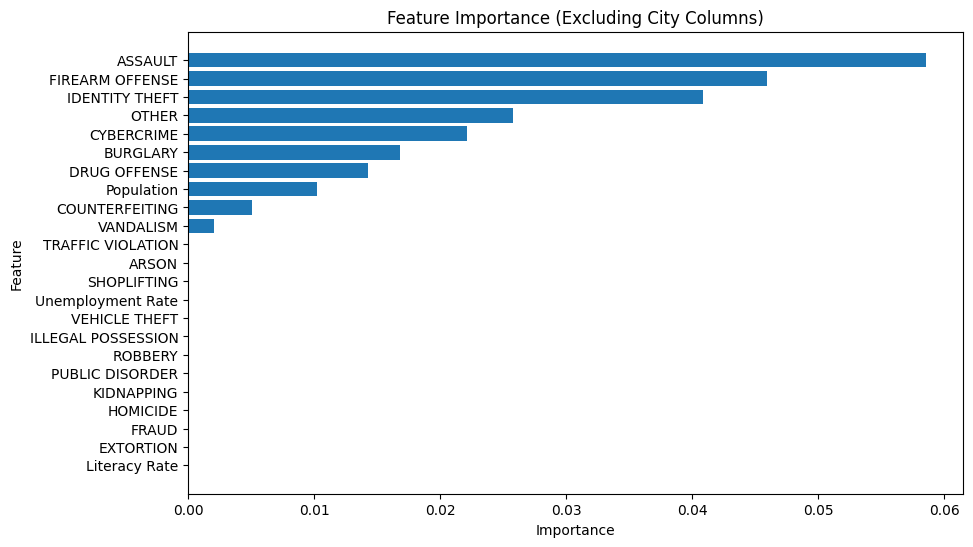

In [65]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Exclude city_columns from feature importance
non_city_columns = [col for col in X.columns if col not in city_columns]

# Create a new DataFrame with feature importance values
feature_importance = pd.DataFrame({
    'Feature': non_city_columns,
    'Importance': xgModel.feature_importances_[:len(non_city_columns)]  # Exclude city_columns
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Excluding City Columns)')
plt.gca().invert_yaxis()
plt.show()